Monocular depth estimation is a computer vision task that involves predicting the depth information of a scene from a single image. In other words, it is the process of estimating the distance of objects in a scene from a single camera viewpoint.

Monocular depth estimation has various applications, including 3D reconstruction, augmented reality, autonomous driving, and robotics. It is a challenging task as it requires the model to understand the complex relationships between objects in the scene and the corresponding depth information, which can be affected by factors such as lighting conditions, occlusion, and texture.
The task illustrated in this tutorial is supported by the following model architectures:

DPT, GLPN

In this guide you’ll learn how to:

create a depth estimation pipeline
run depth estimation inference by hand

Before you begin, make sure you have all the necessary libraries installed:

In [1]:
pip install -q transformers

 Depth estimation pipeline

The simplest way to try out inference with a model supporting depth estimation is to use the corresponding pipeline(). Instantiate a pipeline from a checkpoint on the Hugging Face Hub:

In [2]:
from transformers import pipeline

checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/245M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Next, choose an image to analyze:

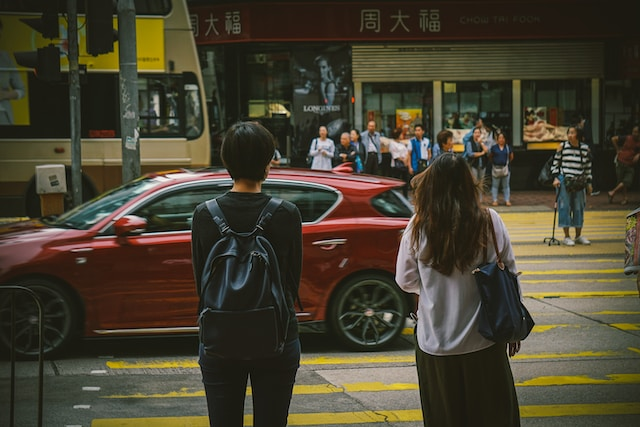

In [3]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/HwBAsSbPBDU/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MzR8fGNhciUyMGluJTIwdGhlJTIwc3RyZWV0fGVufDB8MHx8fDE2Nzg5MDEwODg&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

Pass the image to the pipeline.

In [4]:
predictions = depth_estimator(image)

The pipeline returns a dictionary with two entries. The first one, called predicted_depth, is a tensor with the values being the depth expressed in meters for each pixel. The second one, depth, is a PIL image that visualizes the depth estimation result.

Let’s take a look at the visualized result:

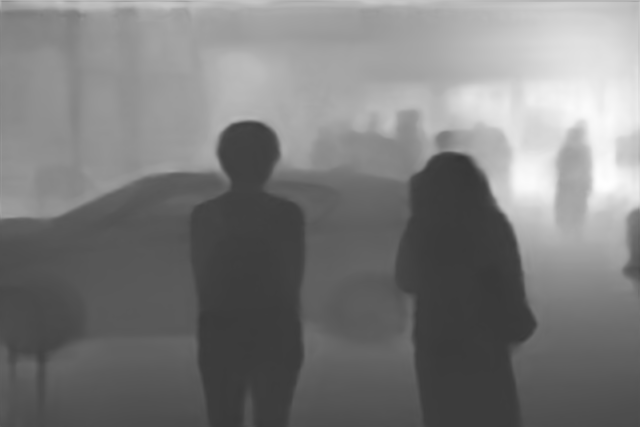

In [5]:
predictions["depth"]

Depth estimation inference by hand

Now that you’ve seen how to use the depth estimation pipeline, let’s see how we can replicate the same result by hand.

Start by loading the model and associated processor from a checkpoint on the Hugging Face Hub. Here we’ll use the same checkpoint as before:

In [6]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

checkpoint = "vinvino02/glpn-nyu"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Prepare the image input for the model using the image_processor that will take care of the necessary image transformations such as resizing and normalization:

In [7]:
pixel_values = image_processor(image, return_tensors="pt").pixel_values

Pass the prepared inputs through the model:

In [8]:
import torch

with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

Visualize the results:

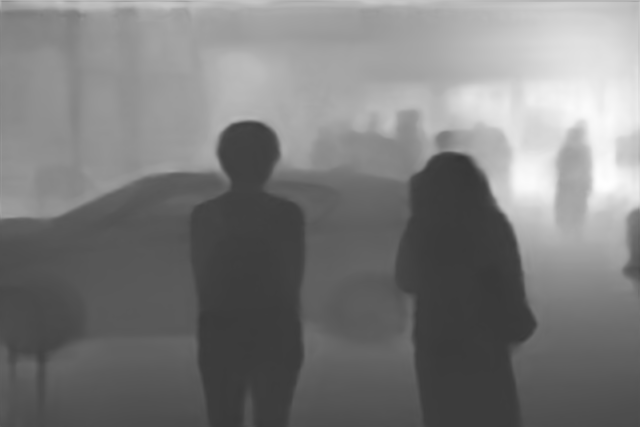

In [9]:
import numpy as np

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()

formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth